# this is used to test matched filter method

In [1]:
# high weight of the RGB and HB

In [2]:
%matplotlib inline
import astropy.io.fits as fits
from astropy.table import Table
import scipy.ndimage as sn
import numpy as np
import csv
import CoordinateConversion as CC
import matplotlib.pyplot as plt
from matplotlib import cm
# import pandas as pd
import math as m
import PyAstronomy as PA
from PyAstronomy import pyasl as PAP
from scipy import signal
import scipy.optimize as SO
import galpy.util.bovy_coords as gub
import finder as fd

In [3]:
# progenitor 1 age 10.1174 gyr

dpath = '/Users/htian/Documents/work/data/SDSS/'
dpath_t = '/Users/htian/Documents/work/data/MF/'
dname = 'sdss.fits'
outputfn = 'Palomar5_3.fits'
fn_t = 'progenitor.1.dat'



In [4]:
Dt = fits.open(dpath+dname)
Dsdss= Dt[1].data
ra = Dsdss['Alpha']
dec = Dsdss['Delta']
gmag = Dsdss['sdss_g']
rmag = Dsdss['sdss_r']
gmr = gmag-rmag
# Dt.close()
# # select the stars around Palomar 5 GC and save the selected data into fits file
# ind = (np.abs(ra-229)<3) & (np.abs(dec<3))
# n = len(ra[ind])
# c1 = fits.Column(name="ra",array=ra[ind],format='F')
# c2 = fits.Column(name="dec",array=dec[ind],format='F')
# c3 = fits.Column(name='gmag',array=gmag[ind],format='F')
# c4 = fits.Column(name='rmag',array=rmag[ind],format='F')
# output = fits.BinTableHDU.from_columns([c1,c2,c3,c4])
# output.writeto(dpath+outputfn)

In [5]:
# DD = fits.open(dpath+outputfn)
# datap = DD[1].data
# rap = datap['ra']
# decp = datap['dec']
# gmagp = datap['gmag']
# rmagp = datap['rmag']
# gmrp = gmagp-rmagp

In [6]:
# read template file
rmagt,gmagt,yt,xt,zt = np.loadtxt(dpath_t+fn_t,skiprows=39,unpack=True,delimiter=',',\
                  dtype={'names':('rmagt','gmagt','yt','xt','zt'),\
                        'formats':(float,float,float,float,float)},\
                                 usecols=(1,8,28,29,30))
gmrt = gmagt - rmagt

In [7]:
#  generate the template
bs_c = 0.1
bs_m = 0.5
min_c,max_c = -0.5,1.
min_m,max_m = 12,22
n_c = int((max_c-min_c)/bs_c)
n_m = int((max_m-min_m)/bs_m)
m_array = np.linspace(min_m,max_m,n_m+1)
c_array = np.linspace(min_c,max_c,n_c+1)
nTmp, xedges, yedge = np.histogram2d(rmagt,gmrt, bins=(m_array, c_array))
sTmp = sn.gaussian_filter(nTmp,sigma=(0.25,0.25),order=0)
print(np.shape(nTmp))

(20, 15)


[-0.5, 1.5, 22, 12]

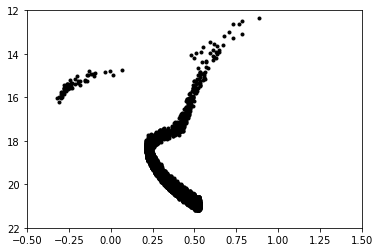

In [8]:
plt.plot(gmagt-rmagt,rmagt,'k.')
plt.axis([-0.5,1.5,22,12])

In [9]:
# # print(np.shape(nTmp0))
# plt.contourf(c_array[:n_c]+bs_c/2,m_array[:n_m]+bs_m/2,nTmp[::-1,:],\
#             levels=np.linspace(0.1,100.1,11),cmap=plt.cm.gist_rainbow,vmin=0.1,vmax=100)
# plt.colorbar()

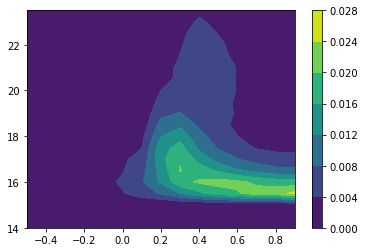

In [10]:
indtbg = (np.abs(dec-40)<5) & (np.abs(ra-180)<5)
T_Bg, xedges, yedges = np.histogram2d(rmag[indtbg],gmr[indtbg],bins=(m_array+2, c_array))
sBg = sn.gaussian_filter(T_Bg/np.sum(T_Bg),sigma=(0.25,0.25),order=0)
sBg = sBg*1.0/np.sum(sBg)#np.sum(nBg)
# print(np.min(sBg))
# print(len(xedges),len(yedges))
# print(len(c_array),len(m_array))
# print(np.shape(T_Bg))
plt.contourf(yedges[:len(yedges)-1],xedges[:len(xedges)-1],T_Bg[::-1,:]/np.sum(T_Bg))
plt.colorbar()

In [11]:
n_background = 10
bs_sky = 0.25
# min_ra,max_ra = 226,232
min_ra,max_ra = 226,234

min_dec,max_dec = -3,5
n_ra = int((max_ra-min_ra)/bs_sky)
n_dec = int((max_dec-min_dec)/bs_sky)
ra_array = np.linspace(min_ra,max_ra,n_ra+1)
dec_array = np.linspace(min_dec,max_dec,n_dec+1)
mf = np.zeros((n_ra,n_dec))
snmf = np.zeros((n_ra,n_dec))
nnn = np.zeros((n_ra,n_dec))
cmf = np.zeros((n_ra,n_dec))
for i in range(0,n_ra):#(14,15):
    c_ra= min_ra+i*bs_sky+bs_sky*0.5
    print(i)
    for j in range(0,n_dec):#(14,15):
        c_dec = min_dec+j*bs_sky+bs_sky*0.5
        ind_a = np.zeros(len(ra))
        ind_c = (np.abs(ra-c_ra)<(bs_sky*0.5)) & (np.abs(dec-c_dec)<(bs_sky*0.5))
        ind_b = (np.abs(ra-c_ra)<(bs_sky*0.5*n_background)) & \
        (np.abs(dec-c_dec)<(bs_sky*0.5*n_background))
        ind_a[ind_b] = 1    # the stars in the background bins
        ind_a[ind_c] = 2    # the stars in the target bin
        nTg, xedges, yedge = np.histogram2d(rmag[ind_a==2],gmr[ind_a==2], \
                                            bins=(m_array+2, c_array))
        if np.sum(nTg)>0:
            ssBg = sBg*np.sum(nTg)
            mf[i,j],cmf[i,j] = fd.Matched_filter(nTg,nTmp*1.0/np.sum(nTmp),ssBg,\
                                    binsize=[bs_c,bs_m])
            del ssBg
#         nnn[i,j] = len(rap[ind_c])
#         res = nTg-sBg
#         res[res<0]=0
#         if np.sum(res)>0:
#             cmf[i,j] = np.max(signal.convolve2d(res/np.sum(res),\
#                                                 nTmp*1.0/np.sum(nTmp),mode='full',\
#                                            boundary='symm'))
            


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [12]:
print(np.shape(mf),np.shape(xedges),np.shape(yedges))

(32, 32) (21,) (16,)


0.0296831680116 4.54010155797


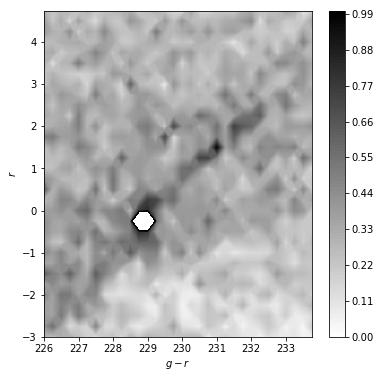

0.790505104477 29.2764372301


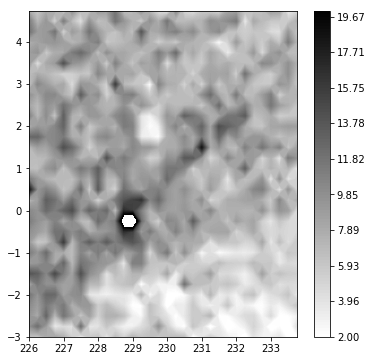

In [24]:
plt.figure(figsize=(6,6))
plt.contourf(ra_array[:len(ra_array)-1],dec_array[:len(dec_array)-1],\
             (mf.T),cmap=plt.cm.binary,\
             vmin=0,vmax=1,levels=np.linspace(0,1,101))#,np.linspace(830,850,101))
plt.colorbar()
plt.xlabel('$g-r$')
plt.ylabel('$r$')
print(np.min(mf.T),np.max(mf))
plt.show()
plt.figure(figsize=(6,6))
plt.contourf(ra_array[:len(ra_array)-1],dec_array[:len(dec_array)-1],\
             (cmf.T),cmap=plt.cm.binary,\
             vmin=2,vmax=20,levels=np.linspace(2,20,111))#,np.linspace(830,850,101))
plt.colorbar()
print(np.min(cmf),np.max(cmf))
plt.show()


In [14]:
nRD, yedges, xedges = np.histogram2d(dec,ra,bins=(dec_array,ra_array))

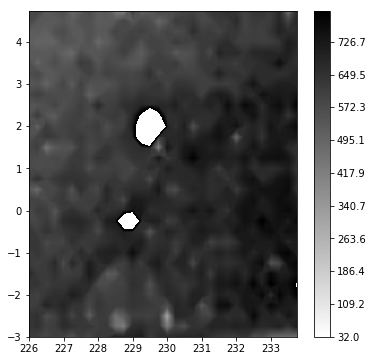

2179.0 276.0


In [15]:
plt.figure(figsize=(6,6))
plt.contourf(xedges[:len(xedges)-1],yedges[:len(yedges)-1],(nRD),\
             levels=np.linspace(32,800,200),cmap=plt.cm.binary)
plt.colorbar()
plt.show()
print(np.max(nRD),np.min(nRD))
# plt.hist(np.log10(nRD+1),bins=20)

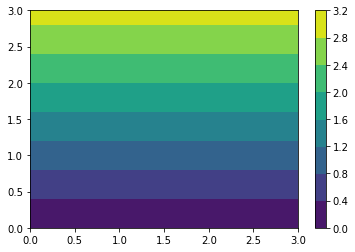

In [16]:
a = np.zeros((4,4))
for i in range(0,4):
    a[i,:] = i
plt.contourf(a)
plt.colorbar()

In [17]:
a = '123'
print(float(a))
b=''
print(len(b))
# print(float(b))

123.0
0
